# The Radon Transform and it's Exact Inverse

Here it will be presented an algorithm that calculates the Radon Transform $R(\alpha,d)$ of an image $F(x,y)$ and also an algorithm that recovers with total accuracy $F$ given $R$.

To first build our way onto this, let's take as an image to be any function $F(x,y)$ defined over the unit square. Thats to say 
<br>

$Domain(F) = \Big[-\cfrac{1}{2},\:\:\cfrac{1}{2}\Big] \times \Big[-\cfrac{1}{2},\:\:\cfrac{1}{2}\Big]$


The image $F$ is also discrete and represented by an $N \times N$ array which we'll call $f$.

By using the standard zero-based indexing :

<br>

$f_{[0][0]} = F(\text{-}\frac{1}{2},\text{-}\frac{1}{2}) \qquad ;\qquad\qquad f_{[0][N-1]} = F(\text{-}\frac{1}{2},\frac{1}{2}) \qquad ;\qquad\qquad f_{[N-1][0]} = F(\frac{1}{2},\text{-}\frac{1}{2}) \qquad ;\qquad\qquad f_{[N-1][N-1]} = F(\frac{1}{2},\frac{1}{2})\qquad ;$

<br>

and at the other indexes, the corresponding $x$'s and $y$'s.

Here's an $8\times8$ image:

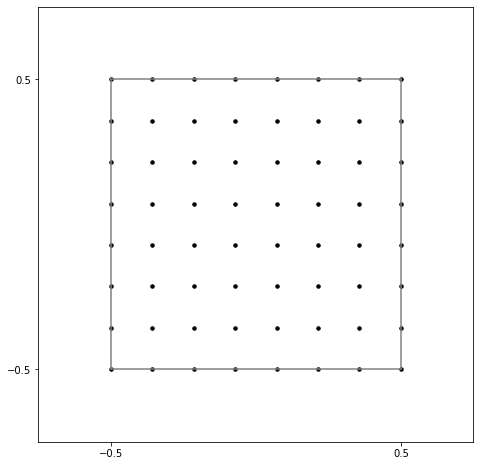

In [26]:
PlotDots(8)

Each point associates an $f_{[i][j]}$. The Radon Transform of $f$ relates to summing up the contribution each point has over an arbitrary given line. However, if we draw a line into the image above, most certainly it will not pass through any of the points. For this reason let's consider points not as literal mathematical points, but 'little' squares:

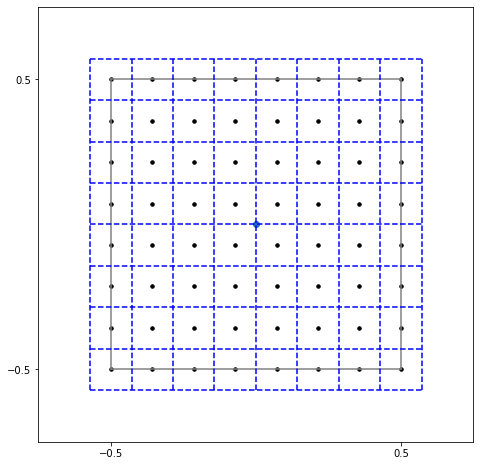

In [27]:
PlotGrid(8)

So a point becomes the little square, which centered at that point. Now let's draw a line. This line is uniquely defined by two parameters, $\alpha$ and $d$, namely the angle it makes and distance it takes from the origin. For example,


$\alpha = \frac{5\pi}{4}\:\:;\:\: d = \frac{\sqrt{2}}{2} $

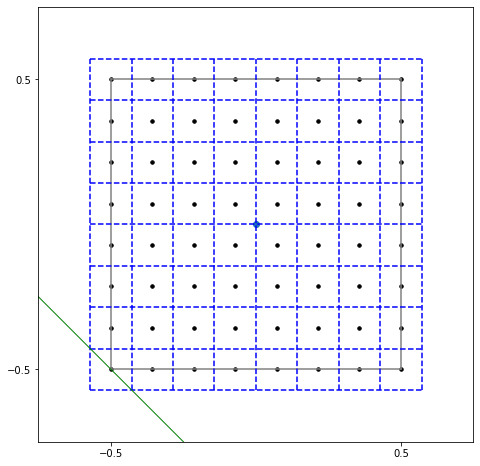

In [28]:
PlotGrid(8)
PlotLine(5*pi/4, sqrt(2)/2)

We can see that the only point contributing to that line is the bottom-left one. In other words, the line 'goes through' only the bottom-left square ($f_{[0][0]}$).

The Radon Transform formula is $R(\alpha,d) = {\displaystyle\int_{line_{\alpha,d}}f \cdot dl}$

In that case, $\;f = f_{[0][0]}\;$, and $\; dl \;$ equals to ... well, the length of the line inside that square! For our $8\times 8$ grid, the little squares have sides $\frac{1}{7}$, therefore:

<br>

$R(\frac{5\pi}{4},\frac{\sqrt{2}}{2}) \: = \: f_{[0][0]} \cdot \frac{\sqrt{2}}{7}$

For each pair $(\alpha, d)$, the length of that line within each square and their corresponding function values, will determine $R_{f}(\alpha, d)$.

________

To calculate $R_{f}(\alpha, d)$:

$\rightarrow$ "Draw" the line parametrized by $\alpha$ and $d$.

$\rightarrow$ For each square $[i,j]$ that line goes through, add up the value $f_{[i][j]}\;\cdot dl_{[i,j]_{\alpha,d}}$

_______

The example above already gave a hint on how to invert the Radon Transform. Suppose that we're given $R$ and asked to find $f$ such that 

$Radon(f) = R$

<br>
Altough at first we don't know any of the values of $f$, we could start by finding the value of the left-bottom one:

<br>

$f_{[0][0]} \: = \: \frac{7}{\sqrt{2}} \cdot R(\frac{5\pi}{4},\frac{\sqrt{2}}{2})$

<br>

There are a total of $N^2$ values to recover and one of them have just been found!


Consider now, for example, this line parametrized by $\alpha = 4.3$ and $d=0.64$  *(nothing particularly special on these numbers)*:

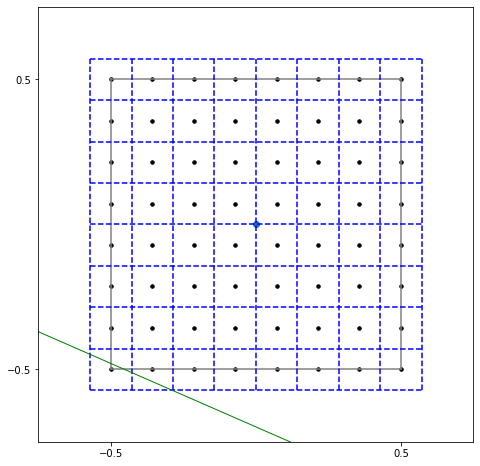

In [29]:
PlotGrid(8)
PlotLine(4.3, 0.64)

This line goes through two squares, $[0,0]$ and $[1,0]$. The line length within each of them are respectively $dl_{[0,0]_{4.3,0.64}}$ and $dl_{[1,0]_{4.3,0.64}}$ which are numbers that can be acquired through geometry. Thus:

$R(4.3, 0.64) = f_{[0][0]} \cdot dl_{[0,0]_{4.3,0.64}} + f_{[1][0]} \cdot dl_{[1,0]_{4.3,0.64}}$

All of the values on the equation above are already known, except for $f_{[1][0]}$. But now we can actually obtain $\;f_{[1][0]}\;$ just by rearranging the equation:


$f_{[1][0]} = \frac{R(4.3, 0.64) - f_{[0][0]} \cdot dl_{[0,0]_{4.3,0.64}}}{dl_{[1,0]_{4.3,0.64}}}$

Now 2 of the $N^2$ unknown values have been found and we can keep finding the new ones with this same methodology.

_____
To calculate the Inverse Radon:

$\rightarrow$ Find a line that goes through exactly one unknown point.

$\rightarrow$ Recover that point using the value of $R(\alpha,d)$, where $(\alpha,d)$ parametrizes the line you've found, and using the values of the other known points that line goes through.
_____

In the code below I've implemented these algorithms. The results have shown to be promising, such that the error $|F - R^{-1}(R(F))|$ obtained is 0. 

So far it works efficiently with small images ($N$ up to $32$). For bigger values I still have to optimize the generation of a structure I named "Kernel", which tells for each line the length inside each square. It only need to be calculated once, so it will work for any $N\times N$ image. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from decimal import *

prec = 32

In [3]:
arccos   = np.arccos
argmax   = np.argmax
array    = np.array
ceil     = np.ceil
cos      = np.cos
linspace = np.linspace
meshgrid = np.meshgrid
pi       = np.pi
sin      = np.sin
sqrt     = np.sqrt

In [4]:
N = 8

h = 1/(N-1)

margin = (1/2) + h/2

dmax = ((1+h)/2)*sqrt(2)

In [5]:
NA = 4*N 
ND = 4*N   

Angl = linspace(0, 2*pi, NA, endpoint=False)
Dist = linspace(0, dmax, ND)

In [6]:
def CrossesGrid(angl, dist, tol=1e-18):
    
    theta = arccos((dist)/(dmax))
    alpha = pi/4 - theta
    
    a1 = alpha
    a2 = a1 + 2*theta
    a3 = a2 + 2*alpha
    a4 = a3 + 2*theta
    a5 = a4 + 2*alpha
    a6 = a5 + 2*theta
    a7 = a6 + 2*alpha
    a8 = a7 + 2*theta
    
    if(angl > a1+tol and angl < a2-tol): return True
    if(angl > a3+tol and angl < a4-tol): return True
    if(angl > a5+tol and angl < a6-tol): return True
    if(angl > a7+tol and angl < a8-tol): return True
    return False

In [7]:
RelevantLine = [[CrossesGrid(angl,dist) for dist in Dist] for angl in Angl]

In [8]:
def DenseLine(angl, dist, density):
    
    dl = (h/density)
    
    bound_adjust = (ceil((dmax)/(dl))*dl) - (dmax)
    
    n_points = int(2*((dmax+bound_adjust)/dl) + 1)
    
    Z = linspace(-(dmax+bound_adjust), dmax+bound_adjust, n_points)
    
    Line_X = dist*cos(angl) - Z*sin(angl)
    Line_Y = dist*sin(angl) + Z*cos(angl)
    
    return [Line_X, Line_Y]

In [9]:
def PointSquare(i, j):
    
    x = -margin + i*h
    y = -margin + j*h
    
    return [x,y]

In [10]:
def Within(Point, Line, density, tol=1e-6):

    x = Point[0]
    y = Point[1]
    
    Line_X = Line[0]
    Line_Y = Line[1]
    
    W = np.sum(np.logical_and(((Line_X>x+tol)&(Line_X<x+h-tol)),((Line_Y>y+tol)&(Line_Y<y+h-tol))))/density
    
    return W  

In [11]:
def GenerateKernel():
    
    density = 100
    
    Kernel  = [[[] for d in range(ND)] for a in range(NA)]
    
    for a in range(NA):
        
        for d in range(ND):
            
            if(not RelevantLine[a][d]): continue
            
            angl = Angl[a]
            dist = Dist[d]
            
            Line = DenseLine(angl, dist, density)
            Line_X = Line[0]
            Line_Y = Line[1]
            
            line_kernel = []
            
            for i in range(N):
                for j in range(N):
                    
                    Point = PointSquare(i,j)
                    
                    W = Within(Point, Line, density)
                    
                    if(W > 0):
                        
                        getcontext().prec = prec
                        
                        dl = Decimal(h)*Decimal(W)
                        
                        line_kernel.append([i,j,dl])
            
            Kernel[a][d] = line_kernel
            
    return Kernel

In [12]:
Kernel = GenerateKernel()

In [13]:
def InverseKernel():
    
    LineInPath = [[False for d in range(ND)] for a in range(NA)]
    
    IKernel = []
    
    Recovered   = [[False for n in range(N)] for nn in range(N)]
    n_recovered =  0
    
    while(n_recovered < N**2):
        
        ADs = []
        IJs = []
        DLs = []
        
        for a in range(NA):
            
            for d in range(ND):
                
                if(not RelevantLine[a][d] or LineInPath[a][d]): continue

                K = Kernel[a][d]
                
                AlreadyRecovered = [Recovered[k[0]][k[1]] for k in K]
                
                if(sum(AlreadyRecovered) == len(K)-1):
                    
                    rec = K[AlreadyRecovered.index(False)]
                    
                    i   = rec[0]
                    j   = rec[1]
                    dl  = rec[2]
                    
                    ADs.append([a,d])
                    IJs.append([i,j])
                    DLs.append(dl)
                    
        
        best = argmax(array(DLs))
        
        Recovered_AD = ADs[best]
        Recovered_IJ = IJs[best]
        Recovered_DL = DLs[best]
        
        IKernel.append([Recovered_AD, Recovered_IJ, Recovered_DL])
        
        LineInPath[Recovered_AD[0]][Recovered_AD[1]] = True
        Recovered[Recovered_IJ[0]][Recovered_IJ[1]] = True
        n_recovered += 1
    
    return IKernel

In [14]:
IKernel = InverseKernel()

In [15]:
def Radon(F):
    
    getcontext().prec = prec
    
    F = [[Decimal(F[i][j]) for j in range(N)] for i in range(N)]
    
    R = [[Decimal(0) for d in range(ND)] for a in range(NA)]
    
    for a in range(NA):
        for d in range(ND):
            
            if(not RelevantLine[a][d]): continue
        
            lk = Kernel[a][d]

            for k in lk:
                
                i  = k[0]
                j  = k[1]
                dl = k[2]
                
                R[a][d] += F[i][j] * dl
                
    return R

In [16]:
def InverseRadon(R):
    
    getcontext().prec = prec

    IR = [[Decimal(0) for n in range(N)] for nn in range(N)]
    
    for IK in IKernel:
        
        a  = IK[0][0]
        d  = IK[0][1]
        i  = IK[1][0]
        j  = IK[1][1]
        dl = IK[2]

        K = Kernel[a][d]
        
        f = sum([IR[k[0]][k[1]]*k[2] for k in K if k[0]!=i or k[1]!=j])
        
        IR[i][j] = (R[a][d]-f)/dl
        
    return array([[np.float64(IR[n][nn]) for n in range(N)] for nn in range(N)]).T

Now I create a random image $F$, apply the Radon Transform, then recover it with the Inverse Radon.

In [17]:
F = np.random.normal(0,1,(N,N))

In [18]:
R = Radon(F)

In [19]:
IR = InverseRadon(R)

The maximum local *error*:

In [20]:
np.max(np.abs(F - IR))

0.0

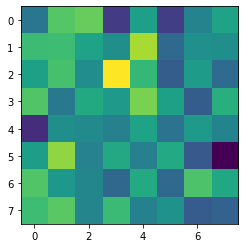

In [21]:
plt.imshow(F);

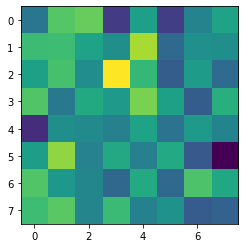

In [22]:
plt.imshow(IR);

_______
#### Plotting functions:

In [23]:
def PlotDots(N):
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_aspect('equal')

    ax.set_xlim([-0.75,0.75])
    ax.set_ylim([-0.75,0.75])
    
    ax.set_xticks([-0.5,0.5])
    ax.set_yticks([-0.5,0.5])
    
    ax.plot([-0.5,-0.5],[-0.5, 0.5],c='grey')
    ax.plot([ 0.5, 0.5],[-0.5, 0.5],c='grey')
    ax.plot([-0.5, 0.5],[-0.5,-0.5],c='grey')
    ax.plot([-0.5, 0.5],[ 0.5, 0.5],c='grey')
    
    U = linspace(-0.5, 0.5, N)
    
    points = meshgrid(U,U)
    
    ax.scatter(points[0], points[1],c='k',s=12)

In [24]:
def PlotGrid(N):
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_aspect('equal')

    ax.set_xlim([-0.75,0.75])
    ax.set_ylim([-0.75,0.75])
    
    ax.set_xticks([-0.5,0.5])
    ax.set_yticks([-0.5,0.5])
    
    ax.scatter(0,0)
    
    ax.plot([-0.5,-0.5],[-0.5, 0.5],c='grey')
    ax.plot([ 0.5, 0.5],[-0.5, 0.5],c='grey')
    ax.plot([-0.5, 0.5],[-0.5,-0.5],c='grey')
    ax.plot([-0.5, 0.5],[ 0.5, 0.5],c='grey')
    
    U = linspace(-0.5, 0.5, N)
    points = meshgrid(U,U)
    
    ax.scatter(points[0], points[1],c='k',s=12)
    
    h = 1/(N-1)
    
    G = linspace(-0.5-h/2, 0.5+h/2, N+1)
    
    for g in G:
        
        ax.plot([G[0],G[-1]],[g,g],'b--')
        ax.plot([g,g],[G[0],G[-1]],'b--')

In [25]:
def PlotLine(angl, dist):
    
    Z = linspace(-sqrt(2)/2, sqrt(2)/2)
    
    X = dist*cos(angl) - Z*sin(angl)
    Y = dist*sin(angl) + Z*cos(angl)

    plt.plot(X,Y,c='g',lw=1)